# Final Demo

## Load Library

In [54]:
import fasttext
import csv
import MeCab
import random
import numpy as np
from tqdm import tqdm
import pickle

import torch
import gluonnlp as nlp
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from CustomModel import BERTClassifier

from text import Text, Word
from infer import predict
from attacks import GreedyAttack, GeneticAttack, PSOAttack, PerturbBaseline

In [88]:
import importlib
import attacks
attacks = importlib.reload(attacks)
GeneticAttack = attacks.GeneticAttack
GreedyAttack = attacks.GreedyAttack
PSOAttack = attacks.PSOAttack
PerturbBaseline = attacks.PerturbBaseline

In [3]:
# load documents
data_path = '/home/ubuntu/workspace/kaist.sbse/proj/data/ratings_test.txt'
ids, documents, targets = [], [], []
with open(data_path, 'r') as f:
    lines = list(csv.reader(f, delimiter='\t'))
    header = lines.pop(0)
    for line in lines:
        ids.append(line[0])
        documents.append(line[1])
        targets.append(int(line[2]))

띄어쓰기 보정

In [22]:
from hanspell import spell_checker

In [31]:
spell_documents = []
for d in tqdm(documents):
    try:
        sent = spell_checker.check(d)
        spell_d = sent.checked
        spell_documents.append(spell_d)
    except:
        spell_documents.append(d)

100%|██████████| 50000/50000 [38:51<00:00, 21.44it/s]


In [65]:
with open('./data/rating_test_spell.pkl', 'wb') as f:
    pickle.dumps({'documents': spell_documents, 'targets': targets, 'target_scores': target_scores}, f)

In [4]:
# load embedding model
embedding_model = fasttext.load_model('/home/ubuntu/workspace/kaist.sbse/proj/data/cc.ko.300.bin')

In [5]:
# load Mecab
tagger = MeCab.Tagger('-d /home/ubuntu/workspace/kaist.sbse/mecab-ko-dic-2.1.1-20180720')

In [56]:
preds, scores = predict(spell_documents, tok, sa_model)

In [64]:
target_scores = []
for t, s in zip(targets, scores):
    target_scores.append(s[t].cpu().numpy())

## Document Data EDA

In [35]:
import matplotlib.pyplot as plt

In [33]:
# filter documents
doc_leng = [len(d.split()) for d in spell_documents]
print(np.mean(doc_leng))

9.51212


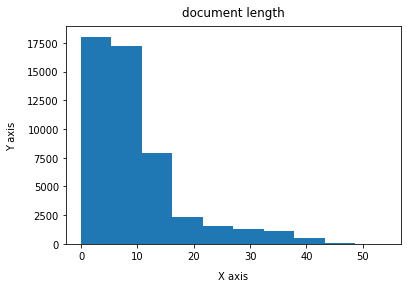

In [36]:
hist = plt.hist(doc_leng, bins=10)

plt.title('document length', pad=10)
plt.xlabel('X axis', labelpad=10)
plt.ylabel('Y axis', labelpad=10)

plt.show()

In [37]:
test = [(d, t) for d, t in zip(spell_documents, targets) if len(d.split()) >= 5 and len(d.split()) < 30]
print(len(test))

34341


## Load Model

In [8]:
# load sentiment model
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# ### argument
# max_len = 64
# batch_size = 64
# ###

bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

sa_model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
checkpoint = torch.load('./model/pytorch_model.bin')['model_state_dict']
sa_model.load_state_dict(checkpoint)

using cached model
using cached model
using cached model


<All keys matched successfully>

## Attacks

In [40]:
# create text obj from documents
random.seed(10)
sample = random.sample(test, 1)[0]
x_orig = sample[0]
adv_target = 0 if sample[1] == 1 else 1
print(sample, x_orig, adv_target)

('기대보다 상당히 재밌게 봤다. 연출도 좋았음.', 1) 기대보다 상당히 재밌게 봤다. 연출도 좋았음. 0


In [10]:
# arguments
pop_size = 50
max_iters = 50
###

### GA

In [75]:
# run attacks (ga) + check sucess rate
ga_attack = GeneticAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
ga_adv, ga_score, ga_count = ga_attack.attack(x_orig, adv_target)

total 5 candidates : ['기대보다', '상당히', '재밌게', '연출도', '좋았음.']
total 5 candidates : ['기대보다', '상당히', '재밌게', '연출도', '좋았음.']
total 5 candidates : ['기대보다', '상당히', '재밌게', '연출도', '좋았음.']
total 5 candidates : ['기대보다', '상당히', '재밌게', '연출도', '좋았음.']
total 5 candidates : ['기대보다', '상당히', '재밌게', '연출도', '좋았음.']
기대보다 has 23 replaces
기대보다 has 23 replaces
기대보다 has 23 replaces
기대보다 has 23 replaces
기대보다 has 23 replaces
상당히 has 22 replaces
상당히 has 22 replaces
상당히 has 22 replaces
상당히 has 22 replaces
상당히 has 22 replaces
재밌게 has 48 replaces
재밌게 has 48 replaces
재밌게 has 48 replaces
재밌게 has 48 replaces
재밌게 has 48 replaces
연출도 has 43 replaces
연출도 has 43 replaces
연출도 has 43 replaces
연출도 has 43 replaces
연출도 has 43 replaces
50
50
50
50
50


<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>
<class 'text.Word'>


In [79]:
# '기대보다 굉장히 놀이하듯 봤다. 연출은 좋았음.' -> 성공
ga_count

(5, 2)

### PSO

In [46]:
# run attacks (pso) + check sucess rate
pso_attack = PSOAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
pso_adv = pso_attack.attack(x_orig, adv_target)

In [49]:
pso_adv

### Greedy

In [50]:
# run attacks (greedy) + check sucess rate
gr_attack = GreedyAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
gr_adv = gr_attack.attack(x_orig, adv_target)

In [53]:
gr_adv.text

'기대치에 약간 임팩트있게 봤다. 무대장치는 좋았음.'

### Perturb Baseline

In [ ]:
# run attack (perterb baseline)
base_attack = PerturbBaseline(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
base_adv = base_attack.attack(x_orig, adv_target)

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


In [ ]:
base_adv

## Success Check

In [80]:
SAMPLE_SIZE = 100
random.seed(1234)
testset = random.sample(test, SAMPLE_SIZE)

(array([1., 3., 1., 3., 1., 5., 4., 0., 2., 4., 3., 3., 4., 2., 0., 1., 3.,
        1., 4., 3., 2., 0., 2., 0., 5., 2., 3., 2., 0., 4., 0., 1., 0., 2.,
        2., 0., 2., 2., 1., 0., 1., 1., 0., 0., 0., 2., 2., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 2., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 14.  ,  14.86,  15.72,  16.58,  17.44,  18.3 ,  19.16,  20.02,
         20.88,  21.74,  22.6 ,  23.46,  24.32,  25.18,  26.04,  26.9 ,
         27.76,  28.62,  29.48,  30.34,  31.2 ,  32.06,  32.92,  33.78,
         34.64,  35.5 ,  36.36,  37.22,  38.08,  38.94,  39.8 ,  40.66,
         41.52,  42.38,  43.24,  44.1 ,  44.96,  45.82,  46.68,  47.54,
         48.4 ,  49.26,  50.12,  50.98,  51.84,  52.7 ,  53.56,  54.42,
         55.28,  56.14,  57.  ,  57.86,  58.72,  59.58,  60.44,  61.3 ,
         62.16,  63.02,  63.88,  64.74,  65.6 

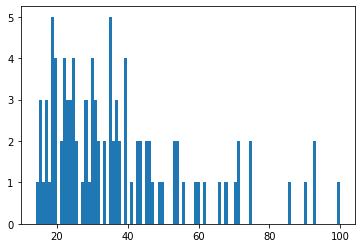

In [83]:
plt.figure()
plt.hist([len(d[0]) for d in testset], bins=100)

In [99]:
# ga_result, gr_result, pso_result, perturb_result = [], [], [], []
ga_attack = GeneticAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
pso_attack = PSOAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
gr_attack = GreedyAttack(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)
base_attack = PerturbBaseline(pop_size=pop_size, max_iters=max_iters, embedding_model=embedding_model, sa_model=sa_model, tokenizer=tok, tagger=tagger)

cnt = 0
error_idx = []
for i, t in enumerate(tqdm(testset[4:])):
    try:
        x_orig = t[0]
        adv_target = 0 if t[1] == 1 else 1
        result = ga_attack.attack(x_orig, adv_target)
        if result is not None:
            ga_result.append(result)
            cnt += 1
            print(f'succeeded {cnt}')
    except:
        error_idx.append(i+4)

  2%|▏         | 2/96 [06:59<4:31:23, 173.23s/it] 

succeeded 1


  3%|▎         | 3/96 [07:53<3:03:48, 118.59s/it]

succeeded 2


  4%|▍         | 4/96 [07:58<1:53:16, 73.87s/it] 

succeeded 3


  5%|▌         | 5/96 [21:19<8:29:39, 336.04s/it]

succeeded 4


  6%|▋         | 6/96 [21:23<5:34:35, 223.06s/it]

succeeded 5


  9%|▉         | 9/96 [1:28:35<19:56:20, 825.06s/it] 

succeeded 6


 10%|█         | 10/96 [1:28:41<13:40:13, 572.25s/it]

succeeded 7


 11%|█▏        | 11/96 [1:28:44<9:23:51, 398.02s/it] 

succeeded 8


 12%|█▎        | 12/96 [1:28:51<6:30:38, 279.03s/it]

succeeded 9


 14%|█▎        | 13/96 [1:29:35<4:47:29, 207.82s/it]

succeeded 10


In [ ]:
len(ga_result)

Error: Session cannot generate requests